In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline
import torch

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import os
import cv2

In [3]:
path_hr = Path('/home/jupyter/data/chest_xray/images')
path_lr = Path('/home/jupyter/data/chest_xray/augment_data')
path_anno = Path('/home/jupyter/data/chest_xray/annotations.csv')

torch.Size([3, 1801, 2078])


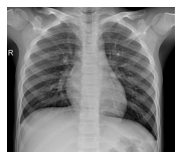

In [4]:
asda = open_image(path_hr/'IM-0684-0001.jpeg')
print(asda.data.shape)
asda.show()

In [5]:
import random, string
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import csv

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        factor = 0
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(factor)
        font = ImageFont.truetype('tmp/arial.ttf', 20)
        img = img.resize(img.size, resample=PIL.Image.BILINEAR).convert('RGB', dither=Image.NONE)
        w,h = img.size
        names = []
        genders = ['M', 'F']
        with open(Path('tmp/names.txt')) as f:
            names= list(f)
        name = str(random.choice(names)) + " " + str(random.choice(names))
        ssn = random.randint(10000000000, 99999999999)
        age = "Age: " + str(random.randint(1, 150))
        sex = "Sex: " + random.choice(genders)
        data1 = str(random.randint(1, 9)) + "/" + str(9)
        data2 = "IM #:"
        data3 = "SE #:"
        data4 = "WL: W:" + str(random.randint(0,360)) + "L: " + str(random.randint(0, 360))
        q = ''.join(random.choice(string.ascii_lowercase) for i in range(random.randint(1, 8)))
        ImageDraw.Draw(img).text((5,5), str(name), fill=(255,255,255), font=font) #first text
        ImageDraw.Draw(img).text((5,65), str(age), fill=(255,255,255), font=font) #second text
        ImageDraw.Draw(img).text((5,95), str(sex), fill=(255,255,255), font=font) #third text
        ImageDraw.Draw(img).text((5,140), str(ssn), fill=(255,255,255), font=font) # fourth text
        ImageDraw.Draw(img).text((w-100, 5), str(name), fill=(255,255,255), font=font) #name right text
        recompute_scale_factor=True
        
        img.save(dest)

In [6]:
from PIL import Image, ImageDraw, ImageFont
from random import randint

In [7]:
il = ImageList.from_folder(path_hr)

In [8]:
print(il)

ImageList (5856 items)
Image (3, 1468, 2026),Image (3, 1430, 1712),Image (3, 768, 1288),Image (3, 1708, 1920),Image (3, 976, 1232)
Path: /home/jupyter/data/chest_xray/images


In [9]:
parallel(crappifier(path_lr, path_hr), il.items)

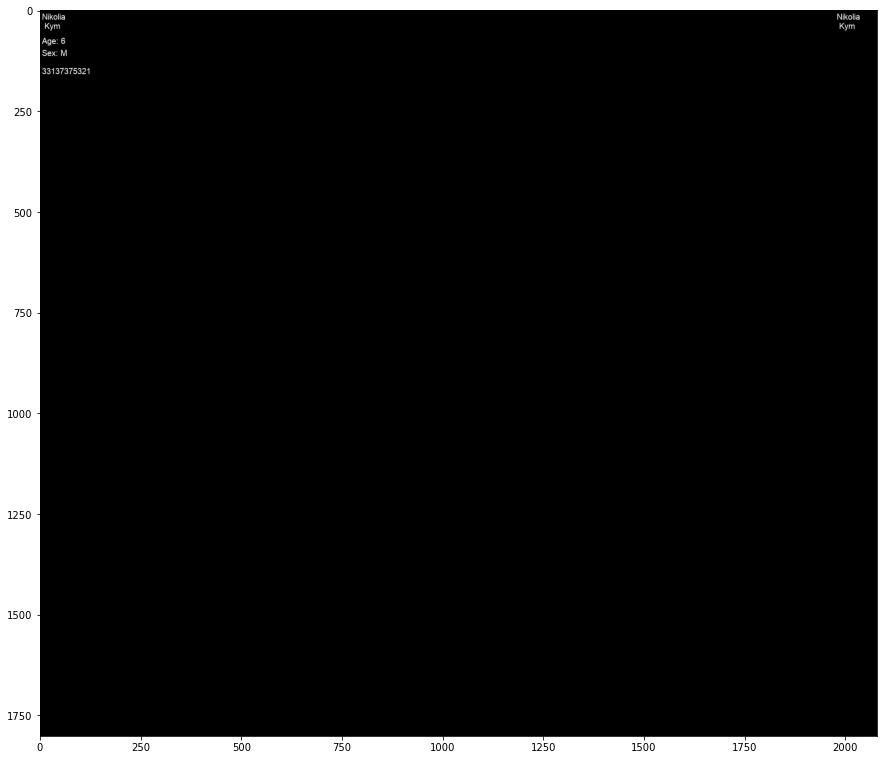

In [10]:
import matplotlib.image as implt
asdasa = path_lr/'IM-0684-0001.jpeg'
test = implt.imread(asdasa)
plt.figure(figsize=(15,15))
imgplot = plt.imshow(test)
#plt.show()

In [151]:
def findBboxes(img_folder):
    img_files = os.listdir(img_folder)
    df_dataset = pd.DataFrame()
    for imgs in range(len(img_files)):
        img=str(img_folder) + '/' + str(img_files[imgs])
        large = cv2.imread(img)
        small = cv2.cvtColor(large, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

        _, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
        connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

        _, contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        mask = np.zeros(bw.shape, dtype=np.uint8)

        #with open("coords.csv","w+") as file:
         #   filewriter = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        bboxes=[]
        for idx in range(len(contours)):
            x, y, w, h = cv2.boundingRect(contours[idx])
            bbox=[x,y,w,h]
            mask[y:y+h, x:x+w] = 0
            bboxes.append(bbox)
            cv2.drawContours(mask, contours, idx, (255, 255, 255), 1)
            r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
            #filewriter.writerow(['file_name', 'bbox', 'cat'])
            #filewriter.writerow((img_files[imgs], bboxes, 'text'))
        
        df_dataset = df_dataset.append(pd.Series([img_files[imgs],bboxes, 'text']), ignore_index=True)                
        
        df_dataset.to_csv('coords.csv')
        path_tmp= Path('/home/jupyter/data/chest_xray/tmp_bbox_folder')
        cv2.imwrite(str(path_tmp/img_files[imgs]),mask)

In [152]:
findBboxes(path_lr)

In [23]:
path_tmp= Path('/home/jupyter/data/chest_xray/tmp_bbox_folder')
len(os.listdir(path_tmp))

5856

In [24]:
len(os.listdir(path_lr))

5856

In [93]:
test = pd.read_csv('coords.csv')

In [94]:
test.head()

,Unnamed: 0,file_name,bbox,cat,0
0,0,NaN,NaN,NaN,NORMAL2-IM-1154-0001-0001.jpeg
1,1,NaN,NaN,NaN,IM-0707-0001.jpeg
2,2,NaN,NaN,NaN,person489_bacteria_2063.jpeg
3,3,NaN,NaN,NaN,NORMAL2-IM-1267-0001.jpeg
4,4,NaN,NaN,NaN,person1063_bacteria_2997.jpeg


In [99]:
test.file_name = test['0']
test.cat = 'text'

In [104]:
test.drop(['0'], axis=1)

,Unnamed: 0,file_name,bbox,cat
0,0,NORMAL2-IM-1154-0001-0001.jpeg,NaN,text
1,1,IM-0707-0001.jpeg,NaN,text
2,2,person489_bacteria_2063.jpeg,NaN,text
3,3,NORMAL2-IM-1267-0001.jpeg,NaN,text
4,4,person1063_bacteria_2997.jpeg,NaN,text
...,...,...,...,...
5851,5851,person351_bacteria_1623.jpeg,NaN,text
5852,5852,person1044_bacteria_2978.jpeg,NaN,text
5853,5853,person1103_bacteria_3044.jpeg,NaN,text
5854,5854,person604_bacteria_2462.jpeg,NaN,text


In [100]:
test.head()

,Unnamed: 0,file_name,bbox,cat,0
0,0,NORMAL2-IM-1154-0001-0001.jpeg,NaN,text,NORMAL2-IM-1154-0001-0001.jpeg
1,1,IM-0707-0001.jpeg,NaN,text,IM-0707-0001.jpeg
2,2,person489_bacteria_2063.jpeg,NaN,text,person489_bacteria_2063.jpeg
3,3,NORMAL2-IM-1267-0001.jpeg,NaN,text,NORMAL2-IM-1267-0001.jpeg
4,4,person1063_bacteria_2997.jpeg,NaN,text,person1063_bacteria_2997.jpeg


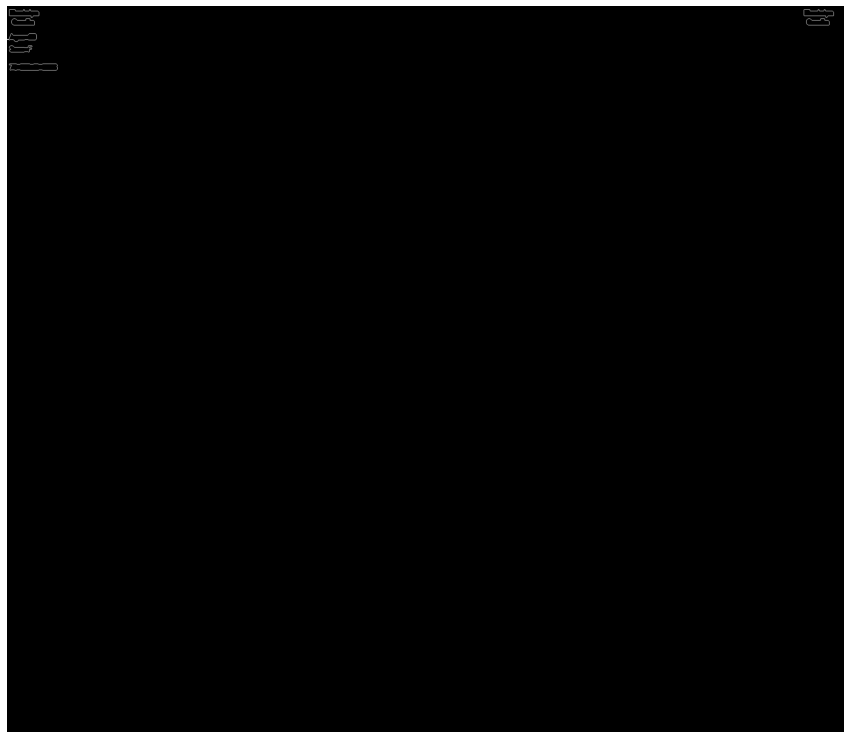

In [63]:
asdasa = open_image('IM-0684-0001_bbox.jpeg')
asdasa.show(figsize=(15,15))

In [64]:
import pandas as pd
df_test = pd.read_csv('coords.csv')

In [65]:
df_test

,file_name,bbox,cat
0,IM-0684-0001.jpeg,"[[5, 143, 121, 17], [5, 98, 58, 17], [0, 68, 7...",text


In [82]:
type(df_test.bbox.array)

pandas.core.arrays.numpy_.PandasArray

In [131]:
box = df_test.bbox.array

In [67]:
import matplotlib.patches as patches
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np

In [128]:
def plt_img_bbox():
    img = ('IM-0684-0001.jpeg')
    bbox_list = []
    bbox_list = df_test.bbox.array 
    #img= img.data[0,:,:]
    print(type(img))
    f, ax = plt.subplots(figsize=(20,20))
    for i in range(len(bboxes)):
        bbox = bboxes[i]
        print(bbox)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], color='r')
        ax.add_artist(rect)

    
    ax.imshow(io.imread(img))
        #ax.imshow(np.array(img))
    plt.xlabel('test')
    #plt.ylabel('asdjk')
    plt.show()

In [129]:
print(bboxes)

[[5, 143, 121, 17], [5, 98, 58, 17], [0, 68, 74, 21], [1984, 31, 58, 17], [11, 31, 58, 17], [1978, 8, 75, 21], [5, 8, 75, 21]]


<class 'str'>
[5, 143, 121, 17]
[5, 98, 58, 17]
[0, 68, 74, 21]
[1984, 31, 58, 17]
[11, 31, 58, 17]
[1978, 8, 75, 21]
[5, 8, 75, 21]


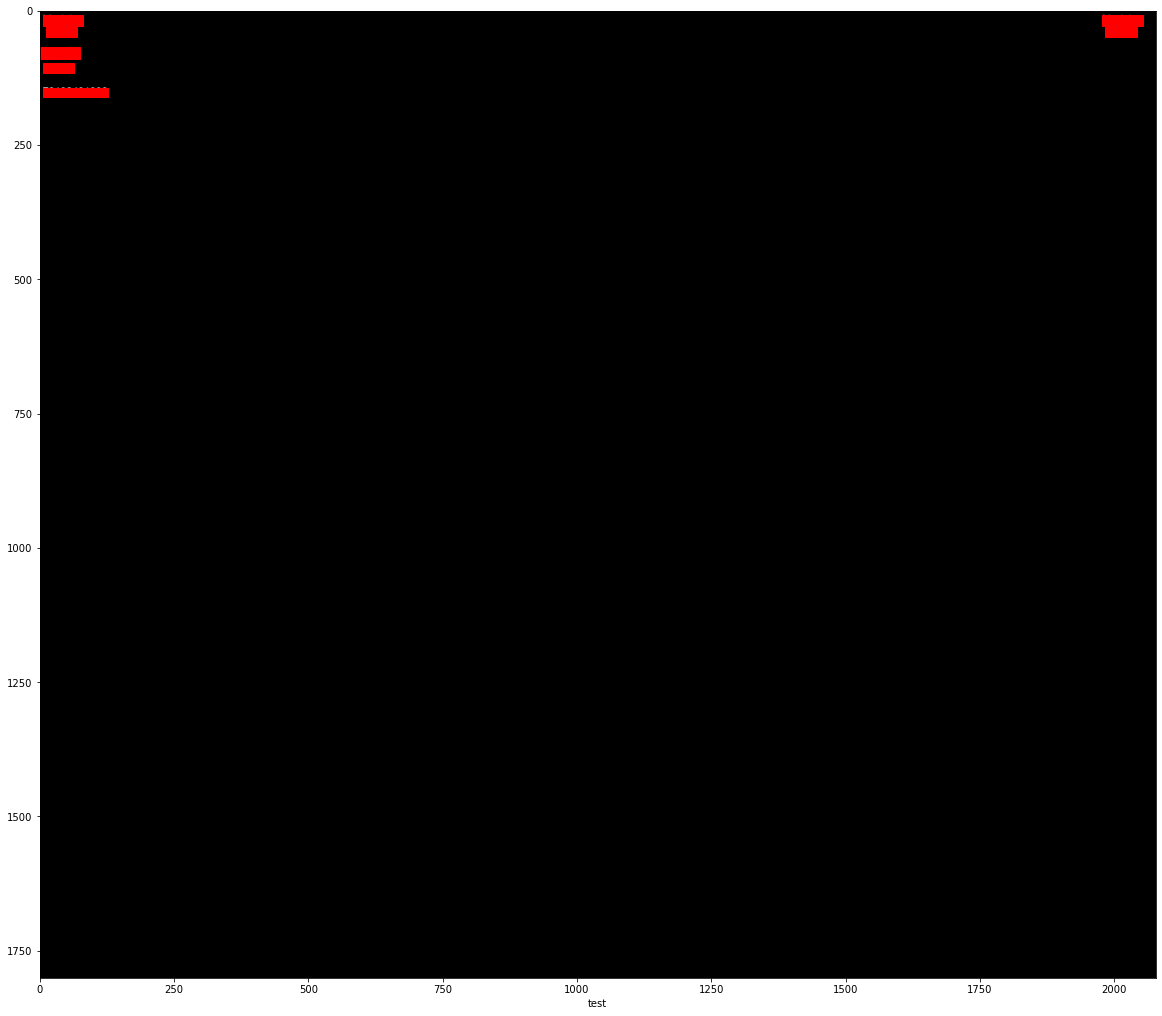

In [130]:
plt_img_bbox()

In [58]:
bbox_list=[]
bbox_list = df_test.bbox.to_numpy()
for i in range(len(bbox_list)):
    bbox = bbox_list[i]
    print(bbox)

[[5, 143, 121, 17], [5, 98, 58, 17], [0, 68, 74, 21], [1984, 31, 58, 17], [11, 31, 58, 17], [1978, 8, 75, 21], [5, 8, 75, 21]]


SyntaxError: invalid syntax (<ipython-input-105-c9eea35cb68a>, line 3)